In [12]:
import sys
sys.path.append("../..")

import numpy as np
import pandas as pd
import pandas_datareader
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from models import MarkowitzMinVarianceModel, SharpeRatioMaxModel

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn')
%matplotlib inline

# pandas precision
pd.options.display.precision = 4

# Read data

In [13]:
# TOPIX Index
df_tpx = pd.read_csv("../../data/tse_topix_20040331-20201031.csv")
df_tpx = df_tpx.set_index("Date")
df_tpx = df_tpx[df_tpx.index >= "2004-10-31"]

# TOPIX Core30 
df_tpx30 = pd.read_csv("../../data/tse_topixcore30_20001031-202010131.csv")
df_tpx30 = df_tpx30.set_index('Date')
df_tpx30 = df_tpx30[df_tpx30.index >= "2004-10-31"]

# back-testing

In [14]:
# Investment period
ST_BACKTEST = datetime(2011,10,31)
ED_BACKTEST = datetime(2020,10,31)

# Risk-free rate (10Year-JGB, monthly interest)
jgb_int = 0.0001 # 0.01% per year (Japanese Government Bond)
r_f = jgb_int * (1/12) # adjust monthly
r_e = r_f

# TOPIX Index
df_tpx = df_tpx.pct_change()
df_tpx[:1] = 0.0 # set 0.0 to the first record

In [15]:
# Params
params = {
    "window_size": 36,
    "rebalance_freq": 1,
    "r_f": r_f
}

# Data
st = (ST_BACKTEST - relativedelta(months=params["window_size"])).strftime('%Y-%m-%d')
ed = ED_BACKTEST.strftime('%Y-%m-%d')
df = df_tpx30[st:ed]
df_re =  df_tpx[st:ed]
params["r_e"] = df_re

# Create model
model = MarkowitzMinVarianceModel(df, **params)

# Backtest by model
df_bt = model.backtest()

# Evaluate
model.evaluate_backtest(logging=True)

Portfolio Performance
Returns per month
  sharpe ratio     : 0.18788996
  mean of returns  : 0.00735206
  std of returns   : 0.03908527
    risk-free rate : 0.00000833
    capgain ratio  : 1.04714952
Returns per year
  sharpe ratio     : 0.65086993
  mean of returns  : 0.08822476
  std of returns   : 0.13539535


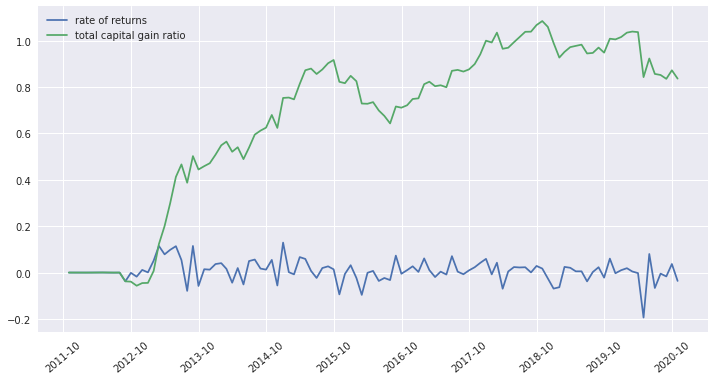

In [5]:
fig = model.plot_returns() # Plot returns

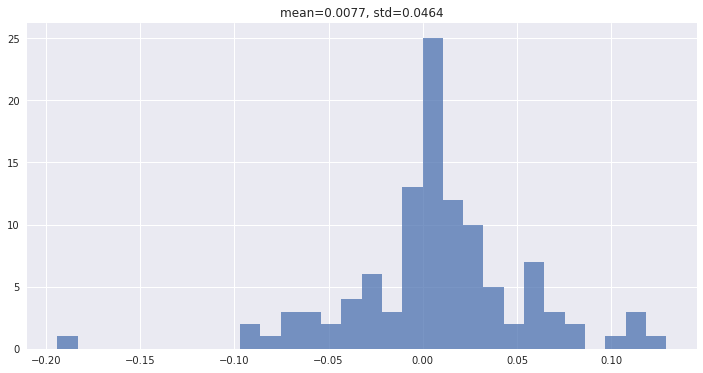

In [6]:
fig = model.plot_returns_histgram()

In [7]:
df_yearly = model.get_yearly_performance()
df_yearly

,ror,std,sharpe_ratio
date,,,
2011-12-31,-0.0001,3.3888e-05,-3.6736
2012-12-31,-0.0444,1.2435e-02,-3.5695
2013-12-31,0.5524,6.5010e-02,8.4973
2014-12-31,0.2448,5.2800e-02,4.6357
2015-12-31,0.0952,4.1543e-02,2.2923
2016-12-31,-0.0970,4.0639e-02,-2.3871
2017-12-31,0.2486,3.0262e-02,8.2144
2018-12-31,-0.0097,3.6705e-02,-0.2644
2019-12-31,0.0254,3.1904e-02,0.7947


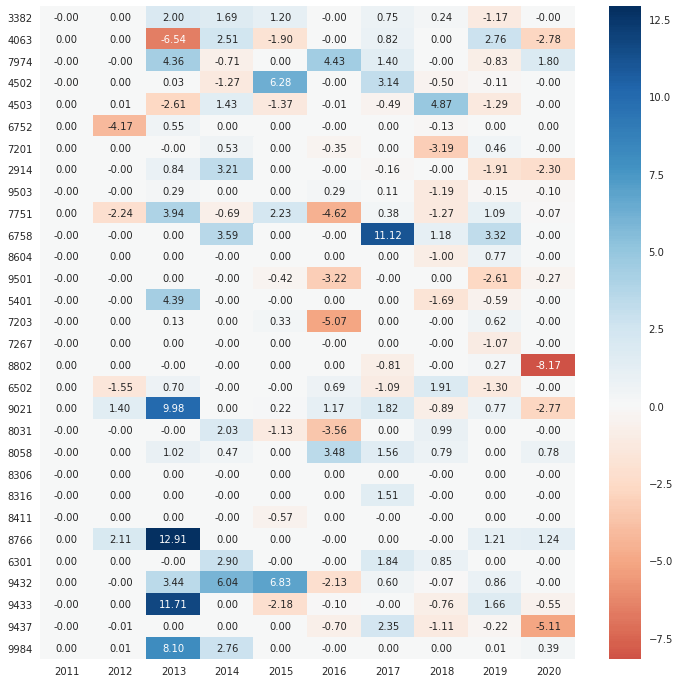

In [8]:
df_bt_r = model.get_dfbt_r() # rate_of_returns
df_bt_x = model.get_dfbt_x() # investment_ratio

df1 = df_bt_r * df_bt_x # (rate_of_returns) × (investment_ratio)

df1 = df1.resample("y").sum()
df1.columns = [c.replace(".T", "") for c in df1.columns]
df1 = df1.T * 100
df1.columns = [c.strftime('%Y') for c in df1.columns]

plt.figure(figsize=(12,12))
sns.heatmap(df1, cmap="RdBu", center=0, annot=True, fmt=".2f", cbar=True)
plt.show()